In [42]:
# College Football Simulation
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from patsy import dmatrices
from team_mapping import team_abbreviations # for matching players from ETR and CFBD on player name, team name

from predictors import Distribution_Manager, Predictor_Manager, Hierarchical_DM, Basic_Predictor
# from BasicPredictor import *

from pydfs_lineup_optimizer import get_optimizer, Site, Sport
# from pydfs_lineup_optimizer.settings import BaseSettings, LineupPosition

In [47]:
class Game:
    def __init__(self, home_team, away_team, offensive_players, df, print=True, max_effective_time=900):
        self.home_team = home_team
        self.away_team = away_team
        self.offensive_players = offensive_players
        self.scores = {self.home_team: 0, self.away_team: 0}
        self.time_left_game = 3600
        self.effective_time_left = 900
        self.max_effective_time = max_effective_time
        self.quarter_time = 900
        self.down = 1
        self.yds_to_go = 10
        self.yds_to_goal = 80
        self.first_down_100 = 70
        self.is_kickoff = True
        self.is_extra_point = True
        self.play_count = 0
        self.quarter = 0
        # Set starting offense
        if random.random() > .5:
            self.offensive_team = self.home_team
            self.defensive_team = self.away_team
        else:
            self.offensive_team = self.away_team
            self.defensive_team = self.home_team
        self.print = print
        self.off_minus_def_score = None
        self.opening_kickoff_receiver = None
        self.is_halftime = False
        # self.offensive_players = [] # list holds active offensive players
        self.DMs = {'run_pass': Hierarchical_DM(df, ['run_vs_pass', 'distance'], 'yards_gained'),
                    'play_t_length': Distribution_Manager(df, 'run_vs_pass', 'play_t_length')}
        self.PMs = {'run_pass': Predictor_Manager(df, 'yards_gained ~ distance+qt_left+yards_to_goal+run_vs_pass'),
                    'play_t_length': Predictor_Manager(df, 'play_t_length ~ run_vs_pass + pos_winning + qt_left')}
        self.basic_predictors = {'run_vs_pass': Basic_Predictor(df, 'run_vs_pass ~ pos_winning*qt_left*yards_to_goal + pos_minus_def_score*qt_left + distance',
                                                                logistic=True),
                                 'punt': Basic_Predictor(df[df['down'] == 4],
                                                         'punt ~ pos_winning+distance+yards_to_goal+qt_left+pos_minus_def_score', logistic=True),
                                 'punt_yds': Basic_Predictor(df[df['punt'] == 1], 'punt_yds ~ yards_to_goal'),
                                 'FG_attempted': Basic_Predictor(df[(df['down'] == 4) & (df['punt'] == 0)],
                                                                 'FG_attempted ~ qt_left+pos_down_three_or_less+yards_to_goal+distance+pos_minus_def_score',
                                                                 logistic=True),
                                 'FG_made': Basic_Predictor(df[df['FG_attempted'] == 1],
                                                                 'FG_made ~ yards_to_goal', # had to take out + pos_team for the low weeks
                                                                 logistic=True),
                                 'fumble': Basic_Predictor(df, 'fumble ~ qt_left + run_vs_pass', logistic=True),
                                 'fumble_lost': Basic_Predictor(df[df['fumble'] == 1], 'fumble_lost ~ run_vs_pass', logistic=True),
                                 'fumble_yds': Basic_Predictor(df[df['fumble'] == 1], 'fumble_spot_yds ~ run_vs_pass'),
                                 'interception': Basic_Predictor(df[df['run_vs_pass'] == 0], 'interception ~ qt_left', logistic=True),
                                 'int_yds': Basic_Predictor(df[df['interception'] == 1], 'int_spot_yds ~ qt_left'),
                                 'pass_complete': Basic_Predictor(df[df['run_vs_pass']==0], 'pass_complete ~ distance + yards_to_goal + qt_left + pos_winning',
                                                                  logistic=True)}
       
        self.all_yards_list = []
        self.fantasy_stats_df = None
        self.is_complete = 0
        
    def display_player_stats(self):
        for player in self.offensive_players:
            player.display_player_stats()
    
    def get_fantasy_points(self):
        fantasy_stats = []
        for player in self.offensive_players:
            fantasy_stats.append({
                "Name": player.name,
                "Position": player.position,
                "Team": player.team,
                "Opponent": player.opponent,
                "FantasyPoints": player.calculate_fantasy_points()
            })
        
        self.fantasy_stats_df = pd.DataFrame(fantasy_stats)
                    
    # def add_player(self, player): # add player to active players on field list
        # self.offensive_players.append(player)
        
    # def remove_player(self, player): # remove player from active list
    #     if player in self.offensive_players:
    #         self.offensive_players.remove(player)
    
    # select players on offense, by position based on play type and offensive share %
    def select_players_by_position(self, players, position):
        return [player for player in players if player.position == position]

    def select_players_by_team(self, players, team):
        return [player for player in players if player.team == team]
    
    def select_players_by_share(self, players, share_type, threshold):
        return [player for player in players if hasattr(player, share_type) and getattr(player, share_type) >= threshold]

    def select_players(self, is_run):
        players_on_offense = self.select_players_by_team(self.offensive_players, self.offensive_team)
        selected_players = []
        
        if is_run:
            probabilities = [player.rush_share for player in players_on_offense]
            selected_players.extend(random.choices(players_on_offense, probabilities, k=1))
        else:
            eligible_receivers = [player for player in players_on_offense if not isinstance(player, Quarterback)]
            quarterbacks = [player for player in players_on_offense if isinstance(player, Quarterback)]
            probabilities = [player.rec_share for player in eligible_receivers]
            
            # select a quarterback every time (most teams have 1 QB with 100% share, but this should handle QB platoons)
            qb_probs = [player.pass_share for player in quarterbacks]
            selected_players.extend(random.choices(quarterbacks, qb_probs, k=1))

            # if eligible_receivers:
            # Randomly select one eligible receiver
            selected_players.extend(random.choices(eligible_receivers, probabilities, k=1))
            
        return selected_players
        
    def update_game_state(self): # score diff, which team is winning, quarter
        if 4 - int(self.time_left_game / 900) > self.quarter:
            print('Quarter: ', self.quarter+1)
        self.quarter = 4 - int(self.time_left_game / 900)
        
        self.off_minus_def_score = self.scores[self.offensive_team] - self.scores[self.defensive_team]
        self.off_down_three_or_less = 1 if -3 <= self.off_minus_def_score <= 0 else 0
        self.offense_winning = 1 if self.off_minus_def_score > 0 else 0
        self.yds_to_go = self.yds_to_goal - self.first_down_100
        if self.quarter_time <= 0:
            self.quarter_time = self.max_effective_time # reset quarter time
        if self.time_left_game > self.max_effective_time:
            self.effective_time_left = self.max_effective_time
        else:
            self.effective_time_left = self.time_left_game
           
    def kickoff(self):
        if self.opening_kickoff_receiver is None:
            self.opening_kickoff_receiver = self.offensive_team
        self.down = 1
        self.yds_to_goal = 80
        self.first_down_100 = 70
        if self.print:
            print('Kickoff: ', self.offensive_team, 'gets the ball at their', self.yds_to_goal, 'yard line')
    
    def start_of_3rd_quarter(self):
        if self.quarter == 3 and not self.is_halftime:
            self.is_halftime = True
            if self.print:
                print('HALFTIME!!')
            # Determine which team receives the 3rd-quarter kickoff
            if self.opening_kickoff_receiver == self.home_team:
                self.offensive_team = self.away_team
                self.defensive_team = self.home_team
            else:
                self.offensive_team = self.home_team
                self.defensive_team = self.away_team
            self.kickoff()
        
    def check_end_game(self):
        if self.time_left_game <= 0:
            return True
                
    def simulate_play(self):
        self.update_game_state()
        
        # check end of game
        if self.check_end_game():
            return True
        # check if kickoff
        if self.is_kickoff:
            self.kickoff() # DO THE KICKOFF
            self.is_kickoff = False
            return
        
        self.start_of_3rd_quarter()
        is_FG = False
        
        # check punt
        is_punt = self.check_and_do_punt()
        if is_punt:
            run_pass = False
        else:
            is_FG, FG_made = self.check_and_do_FG()
            run_pass = not is_FG    
        
        if run_pass: # if play is a run or pass (most of the plays)
            self.play_count += 1
            is_run = self.predict_run_vs_pass()
            
            fumble_or_int, ball_lost, yd_change = self.turnover_check(is_run)
            if fumble_or_int:
                self.move_yds(yd_change, ball_lost, move_yd_str='Fumbled into a 1st down:')
                yards_gained = yd_change # I think this adds or subtracts yards based on where it was fumbled/intercepted?
            else:
                yards_gained = self.run_pass_play(is_run)                                        
                
            t_play = int(self.get_play_t_length(is_run))
            
            # Logic to select player(s) for the play
            selected_players = self.select_players(is_run)
            if is_run:
                selected_players = selected_players[0]
                selected_players.update_rushing_stats(yards_gained)
                if fumble_or_int:
                    selected_players.update_turnovers("fumbles", ball_lost)
            else: # list: quarterback object and receiver object
                is_complete = self.is_complete
                for player in selected_players:
                    if not isinstance(player, Quarterback): # update receiving stats
                        player.update_receiving_stats(yards_gained, is_complete)
                    else:
                        player.update_passing_stats(yards_gained, is_complete) # update QB stats
                        if fumble_or_int:
                            player.update_turnovers("interceptions", ball_lost)
           
            if self.check_TD(): #*is this fucking anything up?
                self.update_touchdown_stat(selected_players, is_run)
            
        else: # not run or pass play -- tick clock by arbitrary constant
            t_play = 10
        
        if not is_FG:
            self.check_TD()  #*is this fucking anything up?
        
        # check whether it is nearing the end of quarter, the time of play can never be longer than time remaining in qtr         
        if t_play >= self.quarter_time:
            t_play = self.quarter_time
        self.time_left_game -= t_play
        self.quarter_time -= t_play
        self.check_4th_down()
        
        # print('Offensive team: ', self.offensive_team, '/nPlay: ', play_type, '/nTime Left: ', self.time_left_game)
    
    def check_punt(self):
        if self.down != 4:
            return False, None
        else:
            is_punt, real_p = self.basic_predictors['punt'].predict(pd.DataFrame.from_dict({'punt': [None],
                                                                             'pos_minus_def_score': [self.off_minus_def_score],
                                                                             'qt_left': [self.quarter_time],
                                                                             'distance': [self.yds_to_go],
                                                                             'pos_winning': [self.offense_winning],
                                                                             #'pos_team': [self.pos_team],
                                                                             #'def_team': [self.def_team],
                                                                             'yards_to_goal': [self.yds_to_goal]}),
                                                                    get_real_p=True) 
        if is_punt:
            punt_yds = self.basic_predictors['punt_yds'].predict(pd.DataFrame.from_dict({'punt_yds': [None],
                                                                             'yards_to_goal': [self.yds_to_goal]}))
            print(self.offensive_team, 'punts from the', self.yds_to_goal, '. It goes', punt_yds, 'yds.')
            return is_punt, punt_yds
        else:
            return is_punt, None
            
    def check_and_do_punt(self):
        is_punt, punt_yds = self.check_punt()
        if is_punt:
           self.move_yds(punt_yds, True, 'Punting the ball. Possession of')
        return is_punt
    
    def check_FG(self):
        if self.down != 4: # if its not 4th down then dont kick FG.. *special case end of half/game situations*
            return False, None
        else:
            is_FG, real_p = self.basic_predictors['FG_attempted'].predict(pd.DataFrame.from_dict({'FG_attempted': [None],
                                                                             'pos_minus_def_score': [self.off_minus_def_score],
                                                                             'pos_down_three_or_less': [self.off_down_three_or_less],
                                                                             'qt_left': [self.quarter_time],
                                                                             #'pos_team': [self.pos_team],
                                                                             #'def_team': [self.def_team],
                                                                             'distance': [self.yds_to_go],
                                                                             'yards_to_goal': [self.yds_to_goal]}),
                                                                    get_real_p=True)
            if is_FG:
                FG_made = self.basic_predictors['FG_made'].predict(pd.DataFrame.from_dict({'FG_made': [None],
                                                                                            #'pos_team': [self.pos_team],
                                                                                            'yards_to_goal': [self.yds_to_goal]}))
                return is_FG, FG_made
            else:
                return is_FG, None
            
    def check_and_do_FG(self):
        is_FG, FG_made = self.check_FG()
        if is_FG:
            if FG_made:
                self.is_kickoff = True
                self.scores[self.offensive_team] += 3
                print('FG is good from ', self.yds_to_goal, '. Score: ', self.get_score_str())
            else:
                print('FG Missed!')
                # self.yds_to_goal += 10 #*what is this?
            self.transfer_possession()
        return is_FG, FG_made
         
    def turnover_check(self, is_run): # check if the play resulted in a turnover
        is_fumble = self.basic_predictors['fumble'].predict(pd.DataFrame.from_dict({'fumble': [None],
                                                                       'pos_winning': [self.offense_winning],
                                                                       'qt_left': [self.quarter_time],
                                                                       'pos_team': [self.offensive_team],
                                                                       'def_team': [self.defensive_team],
                                                                       'run_vs_pass': [is_run]}))
        if is_fumble:
            is_fumble_lost = self.basic_predictors['fumble_lost'].predict(pd.DataFrame.from_dict({'fumble_lost': [None],
                                                                                             'def_team': [self.defensive_team],
                                                                                             'run_vs_pass': [is_run],
                                                                                             'pos_winning': [self.offense_winning]}))
            # TODO: implement Distribution manager here
            fumble_spot_yds = self.basic_predictors['fumble_yds'].predict(pd.DataFrame.from_dict({'fumble_spot_yds': [None],
                                                                                                  #'def_team': [self.defensive_team],
                                                                                                  'run_vs_pass': [is_run],
                                                                                                  'fumble_lost': [is_fumble_lost]}))
            if is_fumble_lost:
                print(self.offensive_team, 'fumbled! Recovered by', self.defensive_team, '!')
            else:
                print(self.offensive_team, 'fumbled! But they recovered it back.')

            return True, is_fumble_lost, int(fumble_spot_yds + 0.5)

        if not is_run:
            return None, None, None
        is_int = self.basic_predictors['interception'].predict(pd.DataFrame.from_dict({'interception': [None],
                                                                                       'pos_winning': [self.offense_winning],
                                                                                       'pos_team': [self.offensive_team],
                                                                                       'def_team': [self.defensive_team],
                                                                                       'qt_left': [self.quarter_time]}))
        if is_int:
            # TODO: implement Distribution manager here
            int_spot_yds = self.basic_predictors['int_yds'].predict(pd.DataFrame.from_dict({'int_spot_yds': [None],
                                                                                            'qt_left': [self.quarter_time]}))
                                                                                           #'def_team': [self.defensive_team]}))
            print(self.offensive_team, 'intercepted by', self.defensive_team, '!')
            return True, True, int(int_spot_yds + 0.5)
        else:
            return None, None, None    

    def move_yds(self, yd_change, ball_lost, move_yd_str=''):
        self.yds_to_goal = float(int(self.yds_to_goal - yd_change))
        if ball_lost:
            self.transfer_possession()
        else:
            if self.is_first_down():
                self.reset_downs()
                print(move_yd_str, self.offensive_team, 'ball. 1st and 10 to go.')
            else:
                self.down += 1              
    
    # predict whether the offensive team will run or pass      
    def predict_run_vs_pass(self):
        is_run, p_run = self.basic_predictors['run_vs_pass'].predict(pd.DataFrame.from_dict({'run_vs_pass': [-999],
                                                                             'pos_minus_def_score': [self.off_minus_def_score],
                                                                             'qt_left': [self.quarter_time],
                                                                             'distance': [self.yds_to_go],
                                                                             'qtr': [self.quarter],
                                                                            #  'pos_team': [self.offensive_team],
                                                                            #  'def_team': [self.defensive_team],
                                                                             'pos_winning': [self.offense_winning],
                                                                             'yards_to_goal': [self.yds_to_goal]}),
                                                            get_real_p=True)
        if self.print:
            print('p(run)=',p_run)
        return is_run
    
    def predict_pass_complete(self):
        pass_play_df = pd.DataFrame.from_dict({'pass_complete': [-999],
                                               'qt_left': [self.quarter_time],
                                               'distance': [self.yds_to_go],
                                               'pos_winning': [self.offense_winning],
                                                'yards_to_goal': [self.yds_to_goal]})
        is_complete = self.basic_predictors['pass_complete'].predict(pass_play_df)
        return is_complete
        
    # run the play, taking in whether run/pass (binary int); return pred_yards gained
    def run_pass_play(self, is_run):
        # create new data to predict yards gained
        current_play_df = pd.DataFrame.from_dict({'distance': [self.yds_to_go],
                                                  'yards_gained': [-999],
                                                  'qt_left': [self.quarter_time],
                                                  'yards_to_goal': [self.yds_to_goal],
                                                  #'pos_team': [self.offensive_team],
                                                  #'def_pos_team': [self.defensive_team],
                                                  'run_vs_pass': [is_run]})
        tile = self.PMs['run_pass'].predict(current_play_df)
        pred_yds_gained = self.DMs['run_pass'].get_val([is_run, self.yds_to_go], tile)
        
        if not is_run:
            is_complete = self.predict_pass_complete()
            self.is_complete = is_complete # store as instance variable to use in simulate_play method
            if not is_complete:
                pred_yds_gained = 0
                print("INCOMPLETE PASS!!")
        
        # predicted yards gained cannot be larger than distance to goalline
        if pred_yds_gained > self.yds_to_goal:
            pred_yds_gained = self.yds_to_goal
            
        self.all_yards_list.append(pred_yds_gained)
        self.yds_to_goal -= pred_yds_gained
        # if play gets first down, reset downs
        if self.is_first_down():
            self.reset_downs()
        else:
            self.down += 1
        if self.down <= 4:
            if self.print:
                print(self.is_run_to_str(is_run, pred_yds_gained), self.offensive_team,'gains',pred_yds_gained,'to',
                      self.yds_to_goal, 'yd line.', self.get_togo_str())
        else:
            print(self.is_run_to_str(is_run, pred_yds_gained), self.offensive_team,'gains',pred_yds_gained,'to', self.yds_to_goal, 'yd line. Transferring possession!' )
        return pred_yds_gained 
        
    def check_4th_down(self):
        if self.down == 5:
            print('Turnover on downs!')
            self.transfer_possession()

    def reset_downs(self):
        self.first_down_100 = self.yds_to_goal - 10
        self.down = 1       
    
    def transfer_possession(self):
        self.yds_to_goal = 100 - self.yds_to_goal
        temp = self.defensive_team
        self.defensive_team = self.offensive_team
        self.offensive_team = temp
        self.reset_downs()
    
    def is_first_down(self):
        if self.yds_to_goal <= self.first_down_100:
            return True
        else:
            return False
    
    def update_touchdown_stat(self, selected_players, is_run):
        if is_run: # Update rushing touchdown
            selected_players.update_touchdowns("rushing_TD")  
        else:
            for player in selected_players:
                if not isinstance(player, Quarterback):
                    player.update_touchdowns("receiving_TD")  # Update receiving touchdown
                else:
                    player.update_touchdowns("passing_TD")  # Update passing touchdown for quarterbacks
                            
    def check_TD(self):
        if self.yds_to_goal <= 0:
            self.scores[self.offensive_team] += 7 #*figure out extra point
            if self.print:
                print()
            print('Touchdown ', self.offensive_team, 'score: ', self.get_score_str())
            self.transfer_possession()
            self.kickoff()
            return True
            
    # def penalty_check(self): #*how to model penalties
        # code here
    
    def get_play_t_length(self, is_run):
        current_play_df = pd.DataFrame.from_dict({'qt_left': [self.quarter_time],
                                                  #'pos_team': self.offensive_team,
                                                  'play_t_length': -999,
                                                  'run_vs_pass': is_run,
                                                  'pos_winning': self.offense_winning})
        tile = self.PMs['play_t_length'].predict(current_play_df)
        if self.print:
            print('---')
            print('play len tile:', tile)
            print('t:', self.DMs['play_t_length'].get_val(is_run, tile))
        return self.DMs['play_t_length'].get_val(is_run, tile)
    
    def is_run_to_str(self, is_run, yd_gain_pred):
        if is_run:
            return 'Run play.'
        else:
            if yd_gain_pred < 0:
                return 'Sack.'
            else:
                return 'Pass play.'

    def get_togo_str(self):
        return str(self.down) +  ' down ' + str(self.yds_to_goal - self.first_down_100) +  ' to go. Time: ' + str(self.time_left_game) + ' Qtr Time: ' + str(self.quarter_time)

    def get_score_str(self):
        return self.home_team + ': ' +  str(self.scores[self.home_team]) + ', ' + self.away_team + ': ' + str(self.scores[self.away_team])
       
    def simulate_game(self):
        play_count = 0
        while self.time_left_game > 0:
            self.simulate_play()
        print('Play count:', self.play_count)
        print('Final:', self.get_score_str())
        # self.get_fantasy_points()
        # return self.fantasy_stats_df
  
                    

class Team:
    def __init__(self, name): #, rushing_percentage, rz_rushing_perc):
        self.name = name
        # self.rushing_percentage = rushing_percentage
        # self.rz_rushing_perc = rz_rushing_perc
    
class Player:
    def __init__(self, name, position, team, opponent, salary, ownership):
        self.name = name
        self.position = position
        self.team = team
        self.opponent = opponent
        self.salary = salary
        self.ownership = ownership
        self.stats = {"rushing_yards":0, "receiving_yards":0, "passing_yards":0, "receptions":0,
                      "rushing_att":0, "completions":0, "pass_att":0, "rushing_TD":0, "passing_TD":0,
                      "receiving_TD":0, "fumbles":0, "interceptions":0, "targets":0, "fumbles_lost":0}
    
    def update_rushing_stats(self, yards):
        self.stats["rushing_yards"] += yards
        self.stats["rushing_att"] += 1
    
    def update_receiving_stats(self, yards, is_complete):
        self.stats["receiving_yards"] += yards
        self.stats["targets"] += 1
        if is_complete:
            self.stats["receptions"] += 1
    
    def update_passing_stats(self, yards, is_complete):
        self.stats["passing_yards"] += yards
        self.stats["pass_att"] += 1
        if is_complete:
            self.stats["completions"] += 1
        
    def update_touchdowns(self, touchdown_type):
        self.stats[touchdown_type] += 1
        
    def update_turnovers(self, turnover_type, ball_lost):
        if ball_lost:
            if turnover_type == "fumbles":
                self.stats["fumbles_lost"] += 1
                self.stats["fumbles"] += 1
            else:
                self.stats[turnover_type] += 1 # interceptions
        else:
            self.stats["fumbles"] += 1
    
    def calculate_fantasy_points(self):
        rec_bonus = 3 if self.stats["receiving_yards"] >= 100 else 0
        rush_bonus = 3 if self.stats["rushing_yards"] >= 100 else 0
        pass_bonus = 3 if self.stats["passing_yards"] >= 300 else 0
        
        total_fantasy_points = (
            self.stats["rushing_yards"] * .1 + self.stats["receiving_yards"] * .1 + self.stats["passing_yards"] * .04 +
            self.stats["rushing_TD"] * 6 + self.stats["receiving_TD"] * 6 + self.stats["passing_TD"] * 4 -
            self.stats["fumbles_lost"] - self.stats["interceptions"] + self.stats["receptions"] + rec_bonus + rush_bonus +
            pass_bonus
        )
        
        return total_fantasy_points
        
        
    def display_player_stats(self):
        print(f"Player: {self.name}, Position: {self.position}")
        print("Rushing Attempts:", self.stats["rushing_att"])
        print("Rushing Yards:", self.stats["rushing_yards"])
        print("Rushing TDs:", self.stats["rushing_TD"])
        print("Targets:", self.stats["targets"])
        print("Receptions:", self.stats["receptions"])
        print("Receiving Yards:", self.stats["receiving_yards"])
        print("Receiving TDs:", self.stats["receiving_TD"])
        print("Passing Attempts:", self.stats["pass_att"])
        print("Completions:", self.stats["completions"])
        print("Passing Yards:", self.stats["passing_yards"])
        print("Passing TDs:", self.stats["passing_TD"])
        print("Interceptions:", self.stats["interceptions"])
        print("Fumbles:", self.stats["fumbles"])
        print("Fumbles Lost:", self.stats["fumbles_lost"])
        
           
class Quarterback(Player):
    def __init__(self, name, team, opponent, salary, ownership, pass_share, rush_share):
        super().__init__(name, "Quarterback", team, opponent, salary, ownership)
        self.pass_share = pass_share
        # self.passing_accuracy = passing_accuracy
        self.rush_share = rush_share
    
    def update_rushing_stats(self, yards):
        super().update_rushing_stats(yards)
    
    def update_passing_touchdown(self):
        self.update_touchdowns("passing_TD")

    def update_fantasy_points(self):
        # Call the base class method to get common fantasy points
        total_fantasy_points = super().update_fantasy_points()
        return total_fantasy_points
    
class RunningBack(Player):
    def __init__(self, name, team, opponent, salary, ownership, rush_share, rec_share):
        super().__init__(name, "Running Back", team, opponent, salary, ownership)
        self.rush_share = rush_share
        self.rec_share = rec_share
    
    def update_receiving_stats(self, yards, is_complete):
        super().update_receiving_stats(yards, is_complete)
        
    def update_rushing_touchdown(self):
        self.update_touchdowns("rushing_TD")

    def update_fantasy_points(self):
        # Call the base class method to get common fantasy points
        total_fantasy_points = super().update_fantasy_points()
        return total_fantasy_points
    
class WideReceiver(Player):
    def __init__(self, name, team, opponent, salary, ownership, rush_share, rec_share):
        super().__init__(name, "Wide Receiver", team, opponent, salary, ownership)
        self.rush_share = rush_share
        self.rec_share = rec_share
    
    def update_rushing_stats(self, yards):
        super().update_rushing_stats(yards)
        
    def update_receiving_touchdown(self):
        self.update_touchdowns("receiving_TD")
    
    def update_fantasy_points(self):
        # Call the base class method to get common fantasy points
        total_fantasy_points = super().update_fantasy_points()
        return total_fantasy_points
                 
class PlayerLoader:
    def __init__(self, etr_file_path, usage_file_path):
        self.etr_file_path = etr_file_path
        self.usage_file_path = usage_file_path
        self.player_usage_manager = None # PlayerUsageManager instance
    
    def map_abbrev_to_team(self, row): # map ETR team name abbrev to full CFBD team name. Uses team_mapping.py
        team_name = row['Team']
        for full_name, abbrev in team_abbreviations.items():
            if team_name in abbrev:
                return full_name
        return "UNKNOWN"
        
    def load_players(self):
        # Load DraftKings player information data
        etr_df = pd.read_csv(self.etr_file_path)
        # map etr team abbreviations to full team names
        etr_df['full_team_name'] = etr_df.apply(self.map_abbrev_to_team, axis=1)
        
        # Load usage information to process
        usage_df = pd.read_csv(self.usage_file_path, encoding='ISO-8859-1')

        # Merge the data frames on name
        merged_df = pd.merge(etr_df, usage_df, left_on=['Name','full_team_name'], right_on=['name','team'], how='left')
        
        # *temporarily drop NAs (some NAs are due to name mismatches or players that do not exist in the player usage table i.e. Travis Hunter)
        merged_df.dropna(subset = ['usg_pass', 'usg_rush'], inplace=True)
        print('etr:', etr_df)
        print('m:', merged_df)
        # Instantiate PlayerUsageManager
        self.player_usage_manager = PlayerUsageManager(merged_df)

        # Get processed data with adjusted usage
        processed_df = self.player_usage_manager.get_processed_data()
        players = []
        
        # processed_df.to_csv('data_after_merge.csv')
        
        for index, row in processed_df.iterrows():
            name = row["Name"]
            team = row["Team"]
            opponent = row["Opponent"]
            position = row["Position"]
            salary = row["Salary"]
            ownership = row["DK Ownership"]

            # Instantiate players using the processed data
            if position == "QB":
                player = Quarterback(name, team, opponent, salary, ownership, pass_share=row["usg_pass"], rush_share=row["usg_rush"])
            elif position == "RB":
                player = RunningBack(name, team, opponent, salary, ownership, rush_share=row["usg_rush"], rec_share=row["usg_pass"])
            elif position == "WR":
                player = WideReceiver(name, team, opponent, salary, ownership, rush_share=row["usg_rush"], rec_share=row["usg_pass"])
            else:
                # Handle other positions if needed
                continue

            players.append(player)

        return players
    
class PlayerUsageManager:
    def __init__(self, df):
        self.df = df
        self.required_columns = ['athlete_id', 'name', 'position', 'team', 'usg_overall', 'usg_pass', 'usg_rush']
        self.validate_columns()
        
    def validate_columns(self):
        if not set(self.required_columns).issubset(self.df.columns):
            raise ValueError("DataFrame is missing required columns.")
        
    def adjust_usage_to_one(self):
        # Extract relevant usage metrics
        player_metrics = self.df[['name', 'team', 'position', 'usg_overall', 'usg_pass', 'usg_rush']]

        for team in player_metrics['team'].unique():
            print(team)
            team_mask = player_metrics['team'] == team
            team_metrics = player_metrics[team_mask]
            
            # Check if the shares add up to 1 for each player
            invalid_sums = team_metrics[
                (team_metrics[['usg_pass', 'usg_rush']].sum(axis=1) != 1)
            ]
            
            if not invalid_sums.empty:
                # Adjust the shares based on position
                qb_mask = team_metrics['position'] == 'QB'
                highest_qb = team_metrics[qb_mask].loc[team_metrics[qb_mask]['usg_pass'].idxmax()]
                print(highest_qb)
                for index, row in team_metrics.iterrows():
                    if row['position'] == 'QB':
                        if row['name'] == highest_qb['name']: # set qb with highest usage on team to 1, other qbs to 0
                            player_metrics.loc[index, 'usg_pass'] = 1
                        else:
                            player_metrics.loc[index, 'usg_pass'] = 0 # set backup QB pass share to 0
                            # player_metrics.loc[index, 'usg_rush'] = 0 # set backup QB rush share to 0
                    else: # update receiving/rushing usage by team
                        rest_of_team = team_metrics[team_metrics['position'] != 'QB']
                        total_share_pass = rest_of_team['usg_pass'].sum()
                        # total_share_rush = rest_of_team['usg_rush'].sum()
                        player_metrics.loc[index, 'usg_pass'] /= total_share_pass
                        # player_metrics.loc[index, 'usg_rush'] /= total_share_rush
                    
                total_share_rush = team_metrics['usg_rush'].sum()
                player_metrics.loc[team_mask, 'usg_rush'] /= total_share_rush              
        # Update the original DataFrame with adjusted values
        self.df.update(player_metrics)

    def get_processed_data(self):
        self.adjust_usage_to_one()
        return self.df
    
class GameSimulator:
    def __init__(self, players, df, num_simulations=1): # takes in list of player objects from given slate and simulates games
        self.players = players
        self.df = df #* can I inherit this from Game class?
        self.unique_matchups = self.find_unique_matchups()
        self.num_simulations = num_simulations

    def find_unique_matchups(self):
        matchups = set()
        for player in self.players:
            matchup_key = tuple(sorted((player.team, player.opponent)))
            matchups.add(matchup_key)
            
        print(list(matchups))    
        return list(matchups)
    
    def instantiate_teams(self, team1_name, team2_name):
        team1 = Team(team1_name)
        team2 = Team(team2_name)
        return team1, team2

    def simulate_games(self):
        results_list = [] # game scores
        fantasy_stats_list = [] # append player fantasy stats after each game sim
        
        # iterate over the matchups in the slate
        for matchup in self.unique_matchups:
            team1_name, team2_name = matchup
            
            # instantiate Team objects
            away_team, home_team = self.instantiate_teams(team1_name, team2_name)

            game_players = [player for player in self.players if player.team in [away_team.name, home_team.name]]
            
            for _ in range(self.num_simulations):
                game = Game(away_team.name, home_team.name, game_players, self.df, print=False)
                game.simulate_game()

                # get game scores
                away_score = game.scores[away_team.name]
                home_score = game.scores[home_team.name]
                results_list.append({'Away': team1_name, 'Home': team2_name, 'Away_Score': away_score, 'Home_Score': home_score})

                # Collect player fantasy data
                for player in game.offensive_players:
                    stats_dict = self.flatten_stats_dict(player.stats)
                    info_dict = {
                        'Player_Name': player.name,
                        'Team': player.team,
                        'Opponent': player.opponent,
                        'Fantasy_Points': player.calculate_fantasy_points(),
                        'Salary': player.salary,
                        'Position': player.position
                        # 'Sim_num': enumerate(player)
                    }
                    info_dict.update(stats_dict)
                    fantasy_stats_list.append(info_dict)
                    
            # after each sim, get optimal lineup
            
            
            
        # Create data frames from the collected data
        results_df = pd.DataFrame(results_list)
        fantasy_data_df = pd.DataFrame(fantasy_stats_list)

        return results_df, fantasy_data_df

    def flatten_stats_dict(self, d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = f'{parent_key}{sep}{k}' if parent_key else k
            if isinstance(v, dict):
                items.extend(flatten_dict(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

In [ ]:
player_loader = PlayerLoader('ETR CFB DraftKings Projections.csv', 'cfb_player_usage.csv')
players = player_loader.load_players()

# set up df
df = pd.read_csv("sample_data.csv", encoding='ISO-8859-1')

simulator = GameSimulator(players, df, num_simulations=1)
results_df, fantasy_stats_df = simulator.simulate_games()


# for matchup, scores in results.items():
    # print(f"{matchup[0]} vs {matchup[1]}: {scores[0]} - {scores[1]}")   

In [62]:
print('Scores:\n', results_df)
print('\nFantasy Stats:\n', fantasy_stats_df)
fantasy_stats_df.to_csv('simulated_projections.csv')

Scores:
    Away  Home  Away_Score  Home_Score
0   TUL  UTSA          10          14
1  IOWA   NEB          10           0
2    AF   BSU          20          20
3    OU   TCU           0          20
4   CMU   TOL          14          17
5   UNM  UTST          27          17
6   AKR  OHIO          21          14
7   ARK  MIZZ          10          24
8   MEM  TEMP           3          14
9    BC   MIA          14           3

Fantasy Stats:
             Player_Name  Team Opponent  Fantasy_Points  Salary       Position  \
0          Frank Harris  UTSA      TUL           16.12    8600    Quarterback   
1          Makhi Hughes   TUL     UTSA            6.00    5900   Running Back   
2         Michael Pratt   TUL     UTSA            9.78    8200    Quarterback   
3         Joshua Cephus  UTSA      TUL           11.50    6500  Wide Receiver   
4    Tykee Ogle-Kellogg  UTSA      TUL            8.00    5000  Wide Receiver   
..                  ...   ...      ...             ...     ...        

In [58]:
# def update_dk_csv(dk_csv): # update .csv file downloaded from draftkings with points


optimizer = get_optimizer(Site.DRAFTKINGS, Sport.COLLEGE_FOOTBALL)
optimizer.load_players_from_csv('DKSalaries.csv')
optimizer.set_min_salary_cap(48000)
for lineup in optimizer.optimize(n=10):
    print(lineup)

 1. QB      Dequan Finn                   QB    TOL            TOL@CMU  26.54          8300.0$   
 2. RB      Andrew Henry                  RB    UNM            UTST@UNM 33.9           3600.0$   
 3. RB      Ashton Jeanty                 RB    BSU            AF@BSU   33.5           7500.0$   
 4. WR      Drake Stoops                  WR    OU             TCU@OU   31.2           6100.0$   
 5. WR      Terrell Vaughn                WR    UTST           UTST@UNM 20.4           6800.0$   
 6. WR      Isaiah Sategna                WR    ARK            MIZZ@ARK 34.2           3900.0$   
 7. FLEX    Cody Schrader                 RB    MIZZ           MIZZ@ARK 36.8           7200.0$   
 8. SUPER FLEX George Holani                 RB    BSU            AF@BSU   30.7           6300.0$   

Fantasy Points 247.24
Salary 49700.00

 1. QB      Dequan Finn                   QB    TOL            TOL@CMU  26.54          8300.0$   
 2. RB      Andrew Henry                  RB    UNM            UTST@UNM 33.

In [3]:
# handle issue where play time = 0 (missing/erroneous data entry)
# handle ties at end of 4th > Overtime
# Add touchbacks, penalties
# team gets rush/pass % attribute to determine probability that they run/pass
# fix punt/FG/go for it decision making
# update pass attempts/completions (give qb accuracy, target catch percentage, model?)
# Add pass play metrics: i.e. ADOT, YAC, Air Yards, probability of catch?
# calculate fantasy points (own class, or just method in class?)
# Incorporate team strength def/off
# how to simulate each game in the slate 'n' times, how many sims are necessary?
# best way to update stats for each player/game/sim? update dict? (player: (game id: stats))

In [385]:
### SINGLE GAME TEST ###

player_loader = PlayerLoader('ETR CFB DraftKings Projections.csv', 'cfb_player_usage.csv')
players = player_loader.load_players()

# sample pbp df
df = pd.read_csv("sample_data.csv", encoding='ISO-8859-1')

game_players = [player for player in players if player.team in ['COL', 'WSU']]

ex_game = Game('COL', 'WSU', game_players, df) 

# [ex_game.add_player(g) for g in game_players]

# Run simulation and store fantasy outputs in a data frame
game_stats_df = ex_game.simulate_game()


# print(game_stats_df)
for player in ex_game.offensive_players:
    player.display_player_stats()

Kickoff:  COL gets the ball at their 80 yard line
p(run)= 0.503132998270753
Pass play. COL gains 10 to 70 yd line. 1 down 10 to go. Time: 3600 Qtr Time: 900
---
play len tile: [0.37317457]
t: 13.0
Quarter:  1
p(run)= 0.5022246773657569
Run play. COL gains -4 to 74 yd line. 2 down 14 to go. Time: 3587 Qtr Time: 887
---
play len tile: [0.50101101]
t: 22.0
p(run)= 0.4344549051948057
COL fumbled! But they recovered it back.
---
play len tile: [0.6735565]
t: 30.0
p(run)= 0.3679929830217434
Run play. COL gains 11 to 67.0 yd line. 4 down 7.0 to go. Time: 3535 Qtr Time: 835
---
play len tile: [0.30577398]
t: 14.0
COL punts from the 67.0 . It goes 36.0 yds.
p(run)= 0.49088888631201855
Run play. WSU gains 9 to 60.0 yd line. 2 down 1.0 to go. Time: 3511 Qtr Time: 811
---
play len tile: [0.89126039]
t: 42.0
p(run)= 0.6273613230786587
Run play. WSU gains 2 to 58.0 yd line. 1 down 10.0 to go. Time: 3469 Qtr Time: 769
---
play len tile: [0.60660526]
t: 28.0
p(run)= 0.48102856349406703
Pass play. WSU 

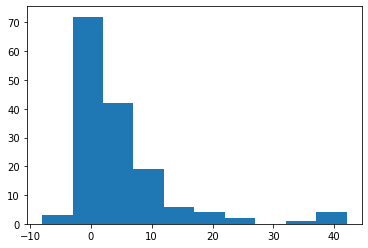

In [386]:
plt.hist(ex_game.all_yards_list)
plt.show()